### This Example Problem has been adapted from one of my Coursework for the Data Science and Machine Learning Module @ Imperial College London

Your first client is **NASA**! They have had a lot of success with their recent **Double Asteroid Redirection Test**, or **DART** mission: now, they have an increased buget and they want to spend it on some predictive machine learning. This is where you come into play: you will help **NASA** train a machine learning algorithm that can determine whether or not a near-Earth asteroid is **hazardous** (dangerous). <br>

### -  First Let's do the required imports and Checkout the data we are working with

In [141]:
import pandas as pd
import numpy as np

data = pd.read_csv('asteroid_training.csv')
unknown_objects = pd.read_csv('unknown_asteroids.csv')
print('Number of Duplicates in the dataset: ', data.duplicated().sum())  # There are no duplicates 

data

Number of Duplicates in the dataset:  0


,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,26150198,Object_26150198,0.031956,0.071456,75374.759095,1.070689e+06,Earth,False,24.60,False
1,7025688,Object_7025688,0.133216,0.297879,33274.114790,1.598217e+07,Earth,False,21.50,False
2,43368461,Object_43368461,0.043507,0.097284,74702.349802,2.330585e+06,Earth,False,23.93,False
3,41099354,Object_41099354,0.012149,0.027167,33078.313997,4.561178e+07,Earth,False,26.70,False
4,25572576,Object_25572576,0.058151,0.130029,51956.093518,3.613123e+06,Earth,False,23.30,False
...,...,...,...,...,...,...,...,...,...,...
9078,36478193,Object_36478193,0.009006,0.020139,23099.050602,5.684655e+06,Earth,False,27.35,False
9079,16202568,Object_16202568,0.265800,0.594347,10471.823883,5.344484e+07,Earth,False,20.00,False
9080,46971691,Object_46971691,0.934448,2.089488,63346.840101,6.688082e+07,Earth,False,17.27,True
9081,14373311,Object_14373311,0.007666,0.017141,23682.903814,4.247773e+05,Earth,False,27.70,False


Description of the Data: 
- The target of our Data is the Hazardous Column

Before any further description of the data, we need to split our dataset into train and test sets so that there is no data-leakage: 


In [89]:
from sklearn.model_selection import train_test_split

y = data.hazardous
X = data.drop(columns='hazardous')

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)  # as we dont have that much data let's choose a train size of 70%

# EDA of our Train Set

In [12]:
print(y_train.value_counts())

False    5770
True      588
Name: hazardous, dtype: int64


From the value counts we can see that our data is not balanced --> we will try to fix this after constructing a baseline model

In [14]:
X_train.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude
1634,35344267,Object_35344267,0.029144,0.065169,32438.053870,1.041869e+07,Earth,False,24.80
5936,46625249,Object_46625249,0.055790,0.124750,39899.786912,5.722143e+07,Earth,False,23.39
5130,13643917,Object_13643917,0.278327,0.622358,81698.972959,5.598045e+07,Earth,False,19.90
2921,19716571,Object_19716571,0.167708,0.375008,68377.688474,6.246283e+07,Earth,False,21.00
3912,43612506,Object_43612506,0.080270,0.179490,33787.963517,3.483622e+07,Earth,False,22.60


From just looking at the feautures, we can see that some of them will lead to no added value to the ML algorithm: These features include the id and name of the Asteroids, as well as the Orbiting_body feature, and sentry_object (As it only has 1 value count). If we kept these, they would bring no new information to the model as well as contribute to a larger amount of features (curse of dimentionality).

#### So let's remove them from our feature lists.

In [15]:
X.drop(columns=['id', 'name', 'orbiting_body', 'sentry_object'], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)  # as we dont have that much data let's choose a train size of 70%

Now that we have removed the unnecessary features, let's look at if any of the features have correlation

<AxesSubplot: >

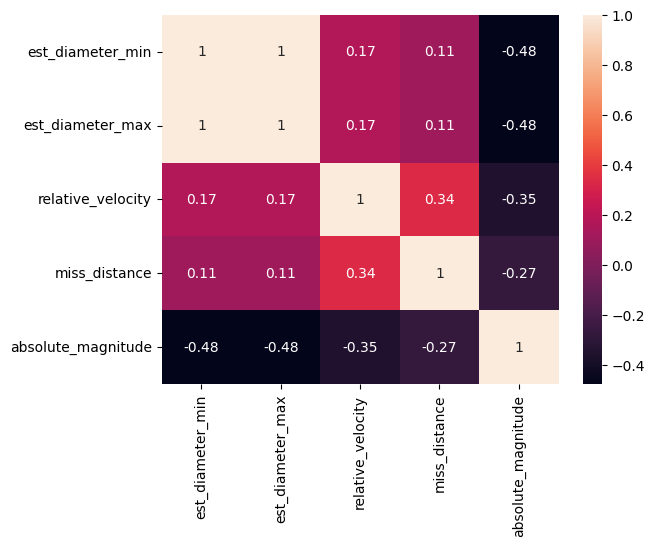

In [16]:
import seaborn as sb

correlation = X_train.corr()

sb.heatmap(correlation, annot=True)

From the correlation matrix, we can clearly see that estimated diameter max and min are correlated, this makes sense as they were predictions.

We will try to manipulate this correlation after our baseline model has been done

Now Let's visualise our features to see if they would need some scaling

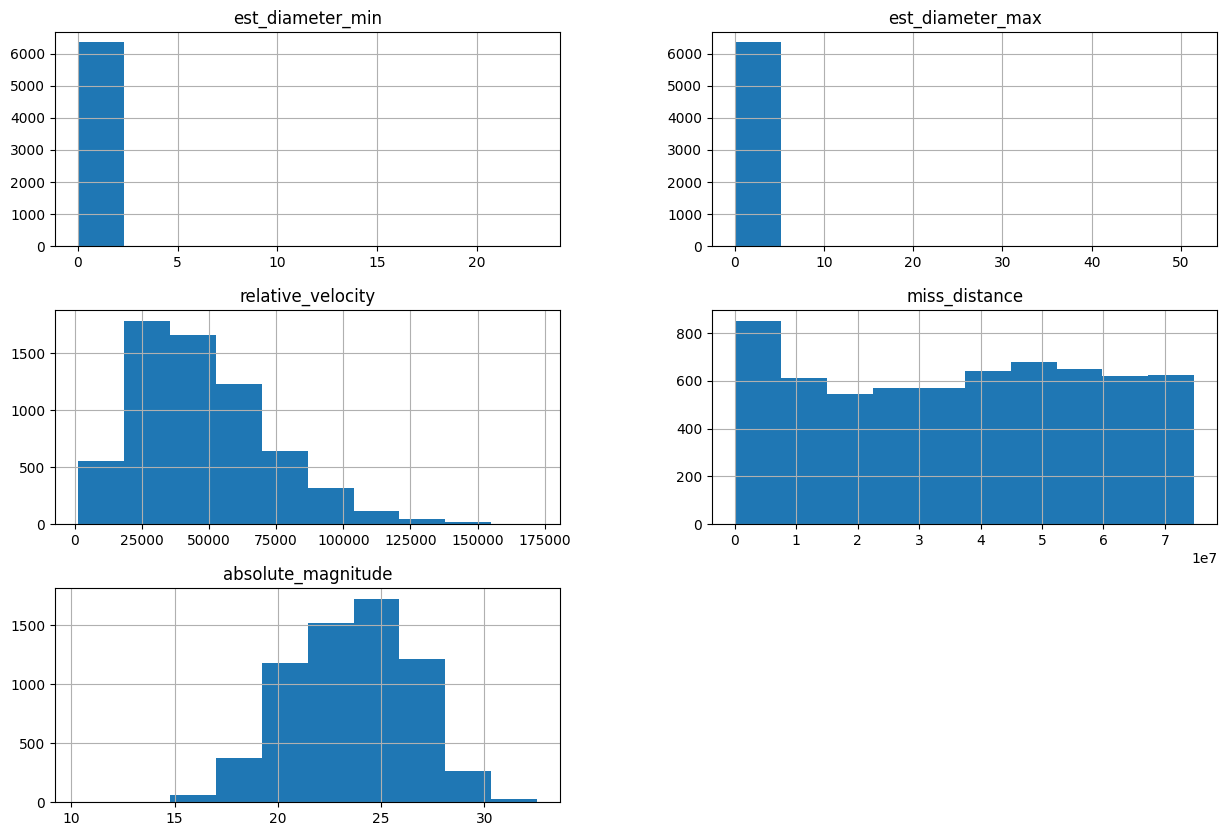

In [17]:
X_train.hist(figsize = (15, 10));

We can see that the relative velocity is quite skewed, the miss distance has varied samples from 0-7. The absolute magnitude is normally distributed but not centred around 0. The min and max diameters would maybe need some feature engineering to get a distribution from them.

From this I think that the absolute magnitude would need a Standard Scale, the relative velocity as well. The miss_distance a MinMax scale, and the estimated diameters maybe get their log values. We will do this after getting a baseline model.

Let's now check to see if they contain any outliers:

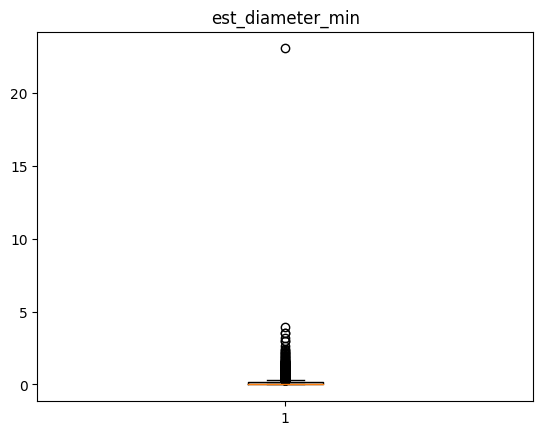

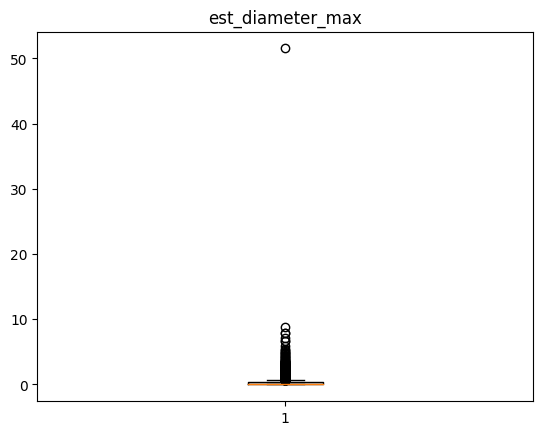

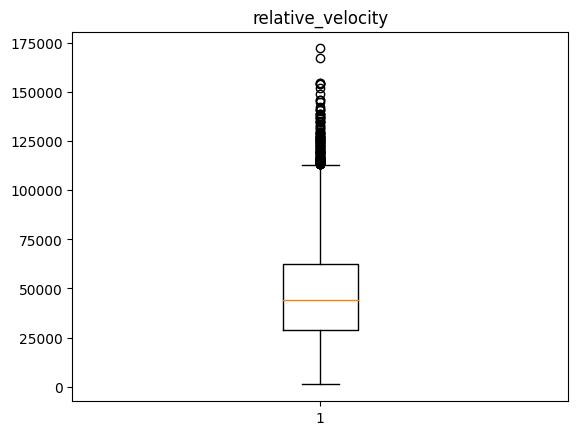

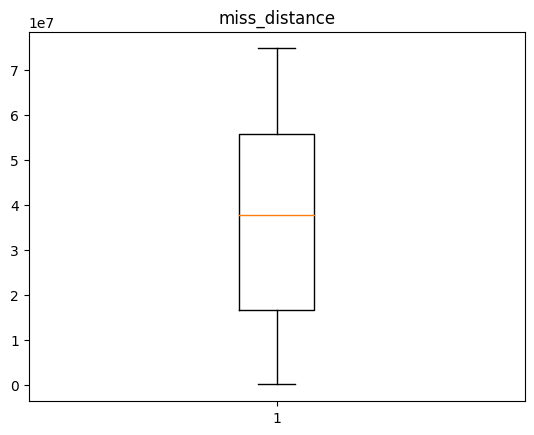

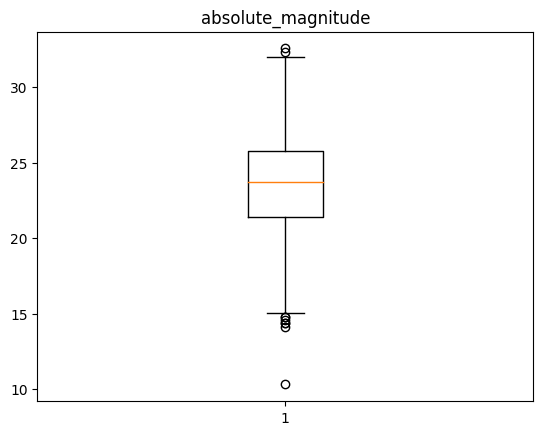

In [18]:
import matplotlib.pyplot as plt

X_columns = X_train.columns
for i in X_columns:
    plt.boxplot(X_train[i]);
    plt.title(str(i))
    plt.show()

From this, we can observe some outliers in the estimation of the diameters of the asteroids, so we could remove those samples that are above 50 (UNITS). 

The realtive velocity has some outliers, so we should apply a Robust scaler to this feature.
The miss distance and absolute magnitude dont seem to contain rough outliers, but maybe the one sample at 10 for absolute magnitude could be. We will try to optimise it more later.

Let's now check for any missing values in these features:

In [19]:
X_train.isnull().sum() 

est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
absolute_magnitude    0
dtype: int64

There doesnt seem to be any missing values in our features, but we could implement a Simple imputer in case there are any in the test set or further tests sets in the feature

So things to optimise after our baseline model would be:
- to fix the correlation between min max diameter estimations, --> maybe apply PCA
- absolute magnitude would need a Robust Scale, the relative velocity as well (because of outliers but theyre normally distributed). 
- The miss_distance a MinMax scale, and the estimated diameters maybe get their log values. 
- Add a Simple Encoder to our final Pipeline incase there are any future null samples (Strategy mean - as we only have numerical features)

Let's now create our baseline Models: Linear-Logistic regression and SVC (Support Vector Classification) - as our probelm here is a classification one. 

As NASA will evaluate your model using a metric that determines the overall performance of the model at all thresholds, we will evalute our models with the AUC_ROC score, as accuracy would not be great as our y vector is not balanced and we want an accurate model at all thresholds.

In [24]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn.metrics import auc

base_Log_regression_model = LogisticRegression(max_iter=1000, random_state=42)
base_SGD_model = SGDClassifier(random_state=42)
base_SVC_model = SVC(random_state=42)

cv_base_LG = cross_validate(base_Log_regression_model, X_train, y_train, cv=10, n_jobs=-1, scoring='roc_auc')
cv_base_SGD = cross_validate(base_SGD_model, X_train, y_train, cv=10, n_jobs=-1, scoring='roc_auc')
cv_base_SVC = cross_validate(base_SVC_model, X_train, y_train, cv=10, n_jobs=-1, scoring='roc_auc')

base_LG_score = cv_base_LG['test_score'].mean()
base_SGD_score = cv_base_SGD['test_score'].mean()
base_SVC_score = cv_base_SVC['test_score'].mean()

print('Baseline Logistic Regression AUC score: ', base_LG_score)
print('Baseline SGD AUC score: ', base_SGD_score)
print('Baseline SVC AUC score: ', base_SVC_score)

Baseline Logistic Regression AUC score:  0.3478094640956113
Baseline SGD AUC score:  0.45599034486810286
Baseline SVC AUC score:  0.5415979486389931


We can see from our baseline models, that the SVC and SGD models have better scores, we will evalute the best model later during the optimisation.

So things to optimise after our baseline model would be:
- to fix the correlation between min max diameter estimations, --> maybe apply PCA
- absolute magnitude would need a Robust Scale, the relative velocity as well (because of outliers but theyre normally distributed). 
- The miss_distance a MinMax scale, 
- The estimated diameters maybe get their log values. 
- Add a Simple Encoder to our final Pipeline incase there are any future null samples (Strategy mean - as we only have numerical features)

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler, FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn import set_config
set_config(display="diagram")


Robust_Scale = RobustScaler()
MinMax_Scale = MinMaxScaler()
transformer = FunctionTransformer(lambda x: np.log(x + 1e-5))

Preproc = make_column_transformer((transformer, ['est_diameter_min', 'est_diameter_min']),(Robust_Scale, ['absolute_magnitude', 'relative_velocity']), (MinMax_Scale, ['miss_distance']))
Pipeline_with_models = Pipeline(([('Preprocessing', Preproc), ('Classifier', SGDClassifier())]))

In [60]:
cv_test = cross_validate(Pipeline_with_models, X_train, y_train, cv=5, n_jobs=-1, scoring='roc_auc')
cv_test_score = cv_test['test_score'].mean()
print('Optimised Logistic regression AUC score: ', cv_test_score)

Optimised Logistic regression AUC score:  0.8726941241481676


We can see that our optimisation has increased our model significantly by over 50%. Let's conduct a gridsearch to see which model performs better.

In [107]:
import warnings
warnings.filterwarnings('ignore')  # To ignore the Warnings

from sklearn.model_selection import GridSearchCV
import scipy.stats as stats

grid = [{'Classifier': [LogisticRegression(random_state=42, max_iter=5000)], 
       'Classifier__penalty':['l1','l2'],
          'Classifier__C': [0.001, 0.01, 0.1],
          'Classifier__class_weight':[None, 'balanced'],
          'Classifier__solver':['liblinear', 'saga']},
       
        # loss='hinge', penalty='l2', keeping learning rate optimal should be fine
        {'Classifier': [SGDClassifier(random_state=42)],
         'Classifier__loss': ['hinge', 'log_loss'],
         'Classifier__penalty': ['l1', 'l2'],
         'Classifier__alpha': [0.0001, 0.001, 0.01,0.1],
         'Classifier__learning_rate': ['optimal', 'adaptive']
        },
        
        #kernel='linear', C=10
        {'Classifier': [SVC(random_state=42)],
         'Classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
         'Classifier__C': [0.001, 0.01, 0.1]
        },
       
       ]

search = GridSearchCV(Pipeline_with_models, grid, cv=10, scoring='roc_auc' , n_jobs=-1)
search.fit(X_train, y_train)

In [44]:
search.best_score_

0.8786035814745448

In [45]:
search.best_params_

{'Classifier': SGDClassifier(alpha=0.001, loss='log_loss', random_state=42),
 'Classifier__alpha': 0.001,
 'Classifier__learning_rate': 'optimal',
 'Classifier__loss': 'log_loss',
 'Classifier__penalty': 'l2'}

Our Best Model seems to be the SGD classifier with the above parameters. Let's make it our optimised_model.

In [61]:
optimised_model = search.best_estimator_

optimised_model_cv = cross_validate(optimised_model, X_train, y_train, cv=10, scoring='roc_auc', n_jobs=-1)
optimised_model_Score = optimised_model_cv['test_score'].mean()

print('Baseline Logistic Regression AUC score: ', base_LG_score)
print('Baseline SGD AUC score: ', base_SGD_score)
print('Baseline SVC AUC score: ', base_SVC_score)
print('Our optimised Models score: ', optimised_model_Score)

Baseline Logistic Regression AUC score:  0.3478094640956113
Baseline SGD AUC score:  0.45599034486810286
Baseline SVC AUC score:  0.5415979486389931
Our optimised Models score:  0.8786035814745448


As we can see, our optimised model does have a significantly higher score. We can try to make it even better now. 

We know that the estimated diameters had correlation so let's try to use PCA on the scaled parameters to see if by removing the correlation our model scores better.

In [62]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)

pipeline_with_pca = Pipeline(([('Preprocessing', Preproc), ('PCA', pca), ('Classification', 
                                                                          SGDClassifier(alpha=0.0001,
                                                                          learning_rate= 'optimal',
                                                                          penalty = 'l2', 
                                                                          loss='log_loss', 
                                                                          random_state=42))]))

In [32]:
cv_with_PCA = cross_validate(pipeline_with_pca, X_train, y_train, cv=10, scoring='roc_auc', n_jobs=-1)
cv_with_PCA_Score = cv_with_PCA['test_score'].mean()
print('Baseline Logistic Regression AUC score: ', base_LG_score)
print('Baseline SGD AUC score: ', base_SGD_score)
print('Baseline SVC AUC score: ', base_SVC_score)
print('Our optimised Models score: ', optimised_model_Score)
print('Our optimised Models with PCA score: ', cv_with_PCA_Score)


Baseline Logistic Regression AUC score:  0.3478094640956113
Baseline SGD AUC score:  0.45599034486810286
Baseline SVC AUC score:  0.5415979486389931
Our optimised Models score:  0.8786035814745448
Our optimised Models with PCA score:  0.8766820765218835


The removal of the correlation with pca seems to decrease the final score, probably because we dont have a big number of features.

We could possibly try doing some feature engineering and add the min-max estimations together, but to try later.
To try later also is the balancing of the dataset.

For now our final model would be the one predicted by our gridsearch.


Let's see how it does on predicting our y_test

In [64]:
Let's see how it does on predicting our y_test
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test,optimised_model.predict(X_test)))
print(roc_auc_score(y_test, optimised_model.predict(X_test)))


              precision    recall  f1-score   support

       False       0.91      0.98      0.95      2477
        True       0.27      0.07      0.11       248

    accuracy                           0.90      2725
   macro avg       0.59      0.52      0.53      2725
weighted avg       0.85      0.90      0.87      2725

0.5247869105447537


- We can see from this that our optimised model has a AUC score of only 53%. Which is quite dissapointing. However I think I know why this is. 
## It is because we have not balanced out our dataset


- Let's do this now using the over-sampling method: 

In [65]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(k_neighbors=5,random_state = 100) 
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

Let's now see if our dataset is more balanced: 

In [66]:
y_train_res.value_counts()

False    5770
True     5770
Name: hazardous, dtype: int64

Great now our dataset is balanced. Let's now conduct our analysis again: 

In [67]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn.metrics import auc

base_Log_regression_model = LogisticRegression(max_iter=1000, random_state=42)
base_SGD_model = SGDClassifier(random_state=42)
base_SVC_model = SVC(random_state=42)

cv_base_LG = cross_validate(base_Log_regression_model, X_train_res, y_train_res, cv=10, n_jobs=-1, scoring='roc_auc')
cv_base_SGD = cross_validate(base_SGD_model, X_train_res, y_train_res, cv=10, n_jobs=-1, scoring='roc_auc')
cv_base_SVC = cross_validate(base_SVC_model, X_train_res, y_train_res, cv=10, n_jobs=-1, scoring='roc_auc')

base_LG_score = cv_base_LG['test_score'].mean()
base_SGD_score = cv_base_SGD['test_score'].mean()
base_SVC_score = cv_base_SVC['test_score'].mean()

print('Baseline Logistic Regression AUC score: ', base_LG_score)
print('Baseline SGD AUC score: ', base_SGD_score)
print('Baseline SVC AUC score: ', base_SVC_score)

Baseline Logistic Regression AUC score:  0.6202367471743224
Baseline SGD AUC score:  0.5588527884323685
Baseline SVC AUC score:  0.5751346383162776


- Unlike with the imbalanced dataset, the logistic regression model seems to perform better here. Let's Continue and check the models with the optimised pipeline we developped and then check for the most effective model with our grid-search:

In [68]:
cv_test = cross_validate(Pipeline_with_models, X_train_res, y_train_res, cv=5, n_jobs=-1, scoring='roc_auc')
cv_test_score = cv_test['test_score'].mean()
print('Optimised Logistic regression AUC score: ', cv_test_score)

Optimised Logistic regression AUC score:  0.9067422783836794


We can see that our optimisation has increased our model significantly by around 27%. Let's conduct a gridsearch to see which model performs better with the same grid as we used previously.

In [71]:
search_2 = GridSearchCV(Pipeline_with_models, grid, cv=10, scoring='roc_auc' , n_jobs=-1)
search_2.fit(X_train_res, y_train_res)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('Preprocessing',
                                        ColumnTransformer(transformers=[('functiontransformer',
                                                                         FunctionTransformer(func=<function <lambda> at 0x7fbfe58f2170>),
                                                                         ['est_diameter_min',
                                                                          'est_diameter_min']),
                                                                        ('robustscaler',
                                                                         RobustScaler(),
                                                                         ['absolute_magnitude',
                                                                          'relative_velocity']),
                                                                        ('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         ['miss_distance'])])),
                                       ('C...
                                                       loss='log_loss',
                                                       random_state=42)],
                          'Classifier__alpha': [0.0001, 0.001, 0.01, 0.1],
                          'Classifier__learning_rate': ['optimal', 'adaptive'],
                          'Classifier__loss': ['hinge', 'log_loss'],
                          'Classifier__penalty': ['l1', 'l2']},
                         {'Classifier': [SVC(random_state=42)],
                          'Classifier__C': [0.001, 0.01, 0.1, 1],
                          'Classifier__kernel': ['linear', 'poly', 'rbf',
                                                 'sigmoid']}],
             scoring='roc_auc')

In [72]:
search_2.best_score_

0.9400343616807187

In [73]:
search_2.best_params_

{'Classifier': LogisticRegression(C=1, max_iter=5000, penalty='l1', random_state=42,
                    solver='saga'),
 'Classifier__C': 1,
 'Classifier__class_weight': None,
 'Classifier__penalty': 'l1',
 'Classifier__solver': 'saga'}

Our Best Model seems to be the Logistic Regression with the above parameters. Let's make it our optimised_model.

In [75]:
optimised_model = search_2.best_estimator_

optimised_model_cv = cross_validate(optimised_model, X_train_res, y_train_res, cv=10, scoring='roc_auc', n_jobs=-1)
optimised_model_Score = optimised_model_cv['test_score'].mean()

print('The following scores are after balancing the dataset:')
print()
print('Baseline Logistic Regression AUC score: ', base_LG_score)
print('Baseline SGD AUC score: ', base_SGD_score)
print('Baseline SVC AUC score: ', base_SVC_score)
print('Our optimised Models score: ', optimised_model_Score)

The following scores are after balancing the dataset:

Baseline Logistic Regression AUC score:  0.6202367471743224
Baseline SGD AUC score:  0.5588527884323685
Baseline SVC AUC score:  0.5751346383162776
Our optimised Models score:  0.9400343616807187


As we can see, our optimised model does have a significantly higher score.

Let's test out our PCA again to see if it does any better than with the imbalanced dataset: 

In [76]:
cv_with_PCA = cross_validate(pipeline_with_pca, X_train_res, y_train_res, cv=10, scoring='roc_auc', n_jobs=-1)
cv_with_PCA_Score = cv_with_PCA['test_score'].mean()
print('The following scores are after balancing the dataset:')
print()
print('Baseline Logistic Regression AUC score: ', base_LG_score)
print('Baseline SGD AUC score: ', base_SGD_score)
print('Baseline SVC AUC score: ', base_SVC_score)
print('Our optimised Models score: ', optimised_model_Score)
print('Our optimised Models with PCA score: ', cv_with_PCA_Score)


The following scores are after balancing the dataset:

Baseline Logistic Regression AUC score:  0.6202367471743224
Baseline SGD AUC score:  0.5588527884323685
Baseline SVC AUC score:  0.5751346383162776
Our optimised Models score:  0.9400343616807187
Our optimised Models with PCA score:  0.90467336879635


The removal of the correlation with pca still seems to decrease the final score, for the same reasons - that we dont have a too large amount of features in our dataset, therefore we are not really removing anything from the curse of high dimensionality.

Let's see how it does on predicting our y_test

In [77]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test,optimised_model.predict(X_test)))
print(roc_auc_score(y_test, optimised_model.predict(X_test)))


              precision    recall  f1-score   support

       False       0.95      0.85      0.90      2477
        True       0.28      0.59      0.38       248

    accuracy                           0.83      2725
   macro avg       0.62      0.72      0.64      2725
weighted avg       0.89      0.83      0.85      2725

0.7190621459361611


We can see that we are getting a much higher score with our dataset having been rebalanced with over-sampling. This is great news. 

- Let's now train our model on the enterty of our data, and predict the the unknown asteroid data. Of course, we must not forget to balance our data the same way as previously.

In [79]:
y.value_counts()

False    8247
True      836
Name: hazardous, dtype: int64

As we can see our data is quite imbalanced.

In [80]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(k_neighbors=5,random_state = 100) 
X_balanced, y_balanced = sm.fit_resample(X, y)

In [81]:
y_balanced.value_counts()

False    8247
True     8247
Name: hazardous, dtype: int64

### Now our dataset is balanced:

In [82]:
final_model = optimised_model.fit(X_balanced, y_balanced)

unknown_data = pd.read_csv('unknown_asteroids.csv')
unknown_data.drop(columns=['id', 'name', 'orbiting_body', 'sentry_object'], inplace=True)  # drop the not wanted features

In [84]:
prediction = pd.Series(final_model.predict(unknown_data)).apply(lambda x: 0 if x == False else 1)

In [85]:
prediction.to_csv(path_or_buf= 'prediction', index=False)

### Below is an extra feature engineering step to try and remove the collinearity between the diameter_max and diameter_min by simply adding the 2 together

In [86]:
X_balanced['new_diameter'] = X_balanced['est_diameter_min'] + X_balanced['est_diameter_max']
new_X = X_balanced.drop(columns=['est_diameter_min', 'est_diameter_max'])

X_train1, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, train_size=0.7, random_state=42)

In [87]:
new_Preproc = make_column_transformer((Robust_Scale, ['absolute_magnitude', 'relative_velocity', 'new_diameter']), (MinMax_Scale, ['miss_distance']))
new_Pipeline_with_models = Pipeline(([('Preprocessing', new_Preproc), ('Classification', 
                                                                          SGDClassifier(alpha=0.0001,
                                                                          learning_rate= 'optimal',
                                                                          penalty = 'l2', 
                                                                          loss='log_loss', 
                                                                          random_state=42))]))

In [88]:
cv_feature_engineered = cross_validate(new_Pipeline_with_models, X_train1, y_train, cv=10, scoring='roc_auc', n_jobs=-1)
cv_feature_engineered_score = cv_feature_engineered['test_score'].mean()
print('Baseline Logistic Regression AUC score: ', base_LG_score)
print('Baseline SGD AUC score: ', base_SGD_score)
print('Baseline SVC AUC score: ', base_SVC_score)
print('Our optimised Models score: ', optimised_model_Score)
print('Our optimised Models with PCA score: ', cv_with_PCA_Score)
print('Our optimised Models with feature engineering: ', cv_feature_engineered_score)

Baseline Logistic Regression AUC score:  0.6202367471743224
Baseline SGD AUC score:  0.5588527884323685
Baseline SVC AUC score:  0.5751346383162776
Our optimised Models score:  0.9400343616807187
Our optimised Models with PCA score:  0.90467336879635
Our optimised Models with feature engineering:  0.8776035365736821


- It seems that our feature Engineering has not braught a better AUC_ROC score so we will not be implementing it.

# Final Comments: 

- We couldv'e done a larger gridsearch with ensemble models and XGBoost and many more but I had no time to do so during the examination - I will potentially be doing this later when I have free time.


- We also couldve added a simple imputer at the begining of our Pipeline to ensure there are no missing values in the future tests being done with our model or when we bring it to industry.


- Import to check for if the dataset is balanced or not otherwise predictive models would not work as optimally as we would want them to.

# Further Developments

- Let's Check if the more modern models work better in this case with models such as RandomForest and XGBoost: 

These are the scores we are trying to match or beat:

In [91]:
print('The following scores are after balancing the dataset:')
print()
print('Baseline Logistic Regression AUC score: ', base_LG_score)
print('Baseline SGD AUC score: ', base_SGD_score)
print('Baseline SVC AUC score: ', base_SVC_score)
print('Our optimised Models score: ', optimised_model_Score)
print('Our optimised Models with PCA score: ', cv_with_PCA_Score)

The following scores are after balancing the dataset:

Baseline Logistic Regression AUC score:  0.6202367471743224
Baseline SGD AUC score:  0.5588527884323685
Baseline SVC AUC score:  0.5751346383162776
Our optimised Models score:  0.9400343616807187
Our optimised Models with PCA score:  0.90467336879635


## K-Neighbours Classifier: 

In [95]:
from sklearn.neighbors import KNeighborsClassifier

Pipeline_with_KNC = Pipeline(([('Preprocessing', Preproc), ('Classifier', KNeighborsClassifier())]))

cv_test_KNC = cross_validate(Pipeline_with_KNC, X_train_res, y_train_res, cv=5, n_jobs=-1, scoring='roc_auc')
cv_test_score_KNC = cv_test_KNC['test_score'].mean()
print('Optimised K-Neighbours AUC score: ', cv_test_score_KNC)

Optimised Logistic regression AUC score:  0.9217614716651298


## Decision Tree Classifier: 

In [101]:
from sklearn.tree import DecisionTreeClassifier

Pipeline_with_DecisionTree = Pipeline(([('Preprocessing', Preproc), ('Classifier', DecisionTreeClassifier())]))

cv_test_DT = cross_validate(Pipeline_with_DecisionTree, X_train_res, y_train_res, cv=5, n_jobs=-1, scoring='roc_auc')
cv_test_score_DT = cv_test_DT['test_score'].mean()
print('Optimised Decision Tree AUC score: ', cv_test_score_DT)

Optimised Logistic regression AUC score:  0.8977469670710573


## Random Forest Classifier: 

In [97]:
from sklearn.ensemble import RandomForestClassifier


Pipeline_with_RandomForest = Pipeline(([('Preprocessing', Preproc), ('Classifier', RandomForestClassifier())]))

cv_test_RF = cross_validate(Pipeline_with_RandomForest, X_train_res, y_train_res, cv=5, n_jobs=-1, scoring='roc_auc')
cv_test_score_RF = cv_test_RF['test_score'].mean()
print('Optimised Random Forest AUC score: ', cv_test_score_RF)

Optimised Logistic regression AUC score:  0.9797815750505363


## XGBoost Classifier: 

In [100]:
from xgboost import XGBClassifier


Pipeline_with_XGB = Pipeline(([('Preprocessing', Preproc), ('Classifier', XGBClassifier())]))

cv_test_XGB = cross_validate(Pipeline_with_XGB, X_train_res, y_train_res, cv=5, n_jobs=-1, scoring='roc_auc')
cv_test_score_XGB = cv_test_XGB['test_score'].mean()
print('Optimised XGBoost AUC score: ', cv_test_score_XGB)

Optimised Logistic regression AUC score:  0.9826622943630625


### Great, we can see that the Random Forest and XGBoost performed better than our more classical models, no surprise. The Decision Tree and KNeighbours models worked less well. However no hyperparameter tuning was conducted on any of the models, which could be the reason the models are not performing better or as good as they could be.


- Let's now test our new models on the y_test to see how they perform: 

In [106]:
# Let's Train our models: 
Pipeline_with_KNC = Pipeline_with_KNC.fit(X_train_res, y_train_res)
Pipeline_with_DecisionTree = Pipeline_with_DecisionTree.fit(X_train_res, y_train_res)
Pipeline_with_RandomForest = Pipeline_with_RandomForest.fit(X_train_res, y_train_res)
Pipeline_with_XGB = Pipeline_with_XGB.fit(X_train_res, y_train_res)


print('Original Score with Logistic Regression: ', roc_auc_score(y_test, optimised_model.predict(X_test)))
print('Original Score with KNC: ', roc_auc_score(y_test, Pipeline_with_KNC.predict(X_test)))
print('Original Score with Decision Trees: ', roc_auc_score(y_test, Pipeline_with_DecisionTree.predict(X_test)))
print('Original Score with Random Forest: ', roc_auc_score(y_test, Pipeline_with_RandomForest.predict(X_test)))
print('Original Score with XGBoost: ', roc_auc_score(y_test, Pipeline_with_XGB.predict(X_test)))

Original Score with Logistic Regression:  0.7124106294034146
Original Score with KNC:  0.8246887493976844
Original Score with Decision Trees:  0.7096163738653678
Original Score with Random Forest:  0.7579961451808248
Original Score with XGBoost:  0.7414756078502872


## So from this, we can see that actually, it is the KNC which has the best predictive power, followed by Decision Trees. This is quite surprising as XGBoost is very powerful, Hyperparameter Tuning is needed so that our models generalise better. 

## Hyper Parameter Search: Would be good to do a Random Search but decided to just go with the classic Grid Search: 

### Took Well over 1 hour to train: 

In [125]:
grid_2 = [{'Classifier': [XGBClassifier(random_state=42)], 
           'Classifier__eval_metric':['mlogloss'],
          'Classifier__n_estimators': [10, 50, 100],
          'Classifier__learning_rate':[0.05, 0.5, 1],
          'Classifier__min_child_weight':[5, 10, 20], 
          'Classifier__max_depth': [5, 10, 20]},
       
        {'Classifier': [RandomForestClassifier(random_state=42)],
         'Classifier__max_depth': [1, 10, 20, 40, 50],
         'Classifier__n_estimators': [100, 200, 300],
         'Classifier__min_samples_split': [2, 4, 8],
         'Classifier__max_features': [3, 5, 8]
        },
        
        {'Classifier': [KNeighborsClassifier()],
         'Classifier__n_neighbors': [3, 5, 10, 20],
         'Classifier__weights': ['uniform', 'distance'],
         'Classifier__leaf_size': [10, 20, 30],
         'Classifier__algorithm': ['auto', 'ball_tree', 'kd_tree']
         
        },
        
        {'Classifier': [DecisionTreeClassifier(random_state=42)],
         'Classifier__criterion': ['gini', 'entropy', 'log_loss'],
         'Classifier__splitter': ['best', 'random'],
         'Classifier__min_impurity_decrease':[0.0, 0.1, 0.5]
        }
       ]

search_3 = GridSearchCV(Pipeline_with_models, grid_2, cv=5, scoring='roc_auc' , n_jobs=-1, verbose=1)
search_3.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 306 candidates, totalling 1530 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Preprocessing',
                                        ColumnTransformer(transformers=[('functiontransformer',
                                                                         FunctionTransformer(func=<function <lambda> at 0x7fbfe58f2170>),
                                                                         ['est_diameter_min',
                                                                          'est_diameter_min']),
                                                                        ('robustscaler',
                                                                         RobustScaler(),
                                                                         ['absolute_magnitude',
                                                                          'relative_velocity']),
                                                                        ('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         ['miss_distance'])])),
                                       ('Cl...
                          'Classifier__leaf_size': [10, 20, 30],
                          'Classifier__n_neighbors': [3, 5, 10, 20],
                          'Classifier__weights': ['uniform', 'distance']},
                         {'Classifier': [DecisionTreeClassifier(random_state=42)],
                          'Classifier__criterion': ['gini', 'entropy',
                                                    'log_loss'],
                          'Classifier__min_impurity_decrease': [0.0, 0.1, 0.5],
                          'Classifier__splitter': ['best', 'random']}],
             scoring='roc_auc', verbose=1)

In [126]:
search_3.best_score_

0.9837484869146275

In [127]:
search_3.best_params_

{'Classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='mlogloss',
               feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.5, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=20,
               max_leaves=None, min_child_weight=5, missing=nan,
               monotone_constraints=None, n_estimators=100, n_jobs=None,
               num_parallel_tree=None, predictor=None, random_state=42, ...),
 'Classifier__eval_metric': 'mlogloss',
 'Classifier__learning_rate': 0.5,
 'Classifier__max_depth': 20,
 'Classifier__min_child_weight': 5,
 'Classifier__n_estimators': 100}

- Great, trained the model for a very long time for a 0.01% increase. Let's now check out how it predicts the Y test dataset. 

In [131]:
optimised_model_2 = search_3.best_estimator_

optimised_model_cv_2 = cross_validate(optimised_model_2, X_train_res, y_train_res, cv=10, scoring='roc_auc', n_jobs=-1)
optimised_model_Score_2 = optimised_model_cv_2['test_score'].mean()

print('Original Score with Logistic Regression: ', roc_auc_score(y_test, optimised_model.predict(X_test)))
print('Original Score with KNC: ', roc_auc_score(y_test, Pipeline_with_KNC.predict(X_test)))
print('Original Score with Decision Trees: ', roc_auc_score(y_test, Pipeline_with_DecisionTree.predict(X_test)))
print('Original Score with Random Forest: ', roc_auc_score(y_test, Pipeline_with_RandomForest.predict(X_test)))
print('Original Score with XGBoost: ', roc_auc_score(y_test, Pipeline_with_XGB.predict(X_test)))
print('Final AUC Score with optimised XGBoost: ', roc_auc_score(y_test, optimised_model_2.predict(X_test)))

Original Score with Logistic Regression:  0.7124106294034146
Original Score with KNC:  0.8246887493976844
Original Score with Decision Trees:  0.7096163738653678
Original Score with Random Forest:  0.7579961451808248
Original Score with XGBoost:  0.7414756078502872
Final AUC Score with optimised XGBoost:  0.7168856707515595


### Bizarre our optimised XGBoost model did not predict the test set as good as the K-Neighbours Model. 
- Let's try and optimise the KNC now: 

In [132]:
grid_3 = [{'Classifier': [KNeighborsClassifier()],
         'Classifier__n_neighbors': [3, 5, 10, 20],
         'Classifier__weights': ['uniform', 'distance'],
         'Classifier__leaf_size': [10, 20, 30],
         'Classifier__algorithm': ['auto', 'ball_tree', 'kd_tree']
         
        }
       ]

search_4 = GridSearchCV(Pipeline_with_models, grid_3, cv=10, scoring='roc_auc' , n_jobs=-1, verbose=1)
search_4.fit(X_train_res, y_train_res)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('Preprocessing',
                                        ColumnTransformer(transformers=[('functiontransformer',
                                                                         FunctionTransformer(func=<function <lambda> at 0x7fbfe58f2170>),
                                                                         ['est_diameter_min',
                                                                          'est_diameter_min']),
                                                                        ('robustscaler',
                                                                         RobustScaler(),
                                                                         ['absolute_magnitude',
                                                                          'relative_velocity']),
                                                                        ('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         ['miss_distance'])])),
                                       ('Classifier', SGDClassifier())]),
             n_jobs=-1,
             param_grid=[{'Classifier': [KNeighborsClassifier(leaf_size=10,
                                                              n_neighbors=20,
                                                              weights='distance')],
                          'Classifier__algorithm': ['auto', 'ball_tree',
                                                    'kd_tree'],
                          'Classifier__leaf_size': [10, 20, 30],
                          'Classifier__n_neighbors': [3, 5, 10, 20],
                          'Classifier__weights': ['uniform', 'distance']}],
             scoring='roc_auc', verbose=1)

In [134]:
search_4.best_score_

0.9369668908385872

In [135]:
search_4.best_params_

{'Classifier': KNeighborsClassifier(leaf_size=10, n_neighbors=20, weights='distance'),
 'Classifier__algorithm': 'auto',
 'Classifier__leaf_size': 10,
 'Classifier__n_neighbors': 20,
 'Classifier__weights': 'distance'}

In [136]:
optimised_model_3 = search_4.best_estimator_

optimised_model_cv_3 = cross_validate(optimised_model_3, X_train_res, y_train_res, cv=10, scoring='roc_auc', n_jobs=-1)
optimised_model_Score_3 = optimised_model_cv_3['test_score'].mean()

print('Original Score with Logistic Regression: ', roc_auc_score(y_test, optimised_model.predict(X_test)))
print('Original Score with KNC: ', roc_auc_score(y_test, Pipeline_with_KNC.predict(X_test)))
print('Original Score with Decision Trees: ', roc_auc_score(y_test, Pipeline_with_DecisionTree.predict(X_test)))
print('Original Score with Random Forest: ', roc_auc_score(y_test, Pipeline_with_RandomForest.predict(X_test)))
print('Original Score with XGBoost: ', roc_auc_score(y_test, Pipeline_with_XGB.predict(X_test)))
print('Final AUC Score with optimised XGBoost: ', roc_auc_score(y_test, optimised_model_2.predict(X_test)))
print('Final AUC Score with optimised KNC Model: ', roc_auc_score(y_test, optimised_model_3.predict(X_test)))

Original Score with Logistic Regression:  0.7124106294034146
Original Score with KNC:  0.8246887493976844
Original Score with Decision Trees:  0.7096163738653678
Original Score with Random Forest:  0.7579961451808248
Original Score with XGBoost:  0.7414756078502872
Final AUC Score with optimised XGBoost:  0.7168856707515595
Final AUC Score with optimised KNC Model:  0.85169364605988


### Great so Final Model we could use is the KNC Model as we have a final AUC Score of 85%.

Here is our Final Model Pipeline:

In [138]:
optimised_model_3

Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('functiontransformer',
                                                  FunctionTransformer(func=<function <lambda> at 0x7fbfe58f2170>),
                                                  ['est_diameter_min',
                                                   'est_diameter_min']),
                                                 ('robustscaler',
                                                  RobustScaler(),
                                                  ['absolute_magnitude',
                                                   'relative_velocity']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['miss_distance'])])),
                ('Classifier',
                 KNeighborsClassifier(leaf_size=10, n_neighbors=20,
                                      weights='distance'))])

# Final Comments: 
- Before further Implementations we should inclue a Simple Imputer at the start of the pipeline as future data could include some missing values.